# NIPS Tutorial

# Deep GP supervised learning

### Zhenwen Dai and Neil D. Lawrence

### Monday, 3rd December 2017

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

import GPy

import deepgp

import mlai
import teaching_plots as plot 
from gp_tutorial import ax_default, meanplot, gpplot

### Olympic Marathon Data

The first thing we will do is load a standard data set for regression modelling. The data consists of the pace of Olympic Gold Medal Marathon winners for the Olympics from 1896 to present. First we load in the data and plot.

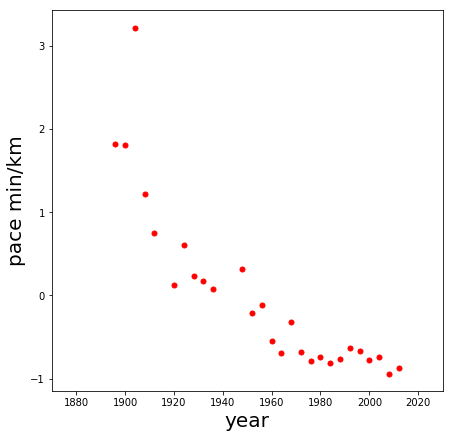

In [2]:
data = GPy.util.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

y = y - y.mean()
y = y/np.sqrt(y.var())
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim((1870,2030))
#ax.set_ylim((2.5,6.5))

plt.savefig('../../slides/diagrams/datasets/olympic-marathon.svg', transparent=True, frameon=True)


Things to notice about the data include the outlier in 1904, in this year, the olympics was in St Louis, USA. Organizational problems and challenges with dust kicked up by the cars following the race meant that participants got lost, and only very few participants completed. 

More recent years see more consistently quick marathons.

Our first objective will be to perform a Gaussian process fit to the data, we'll do this using the [GPy software](https://github.com/SheffieldML/GPy). 

In [3]:
m_full = GPy.models.GPRegression(x,y)
_ = m_full.optimize() # Optimize parameters of covariance function


The first command sets up the model, then 
```
m_full.optimize()
```
optimizes the parameters of the covariance function and the noise level of the model. Once the fit is complete, we'll try creating some test points, and computing the output of the GP model in terms of the mean and standard deviation of the posterior functions between 1870 and 2030. We plot the mean function and the standard deviation at 200 locations. We can obtain the predictions using
```
y_mean, y_var = m_full.predict(xt)
```

In [4]:
xt = np.linspace(1870,2030,200)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

Now we plot the results using the helper function ```gpplot```. 

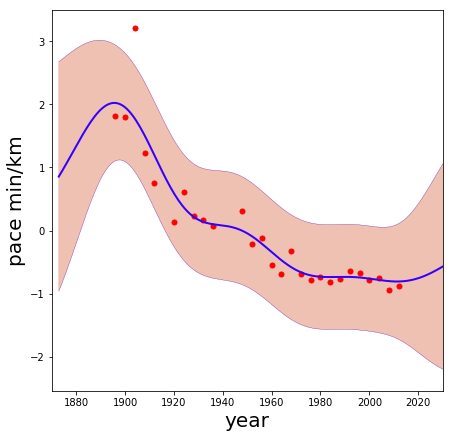

In [5]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
def plot_model_output(model, ax=None, xlabel='$x$', ylabel='$y$', fontsize=20, portion=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=plot.big_figsize)
    ax.plot(model.X, model.Y, 'r.',markersize=10)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    xt = plot.pred_range(model.X, portion=portion)
    yt_mean, yt_var = model.predict(xt)
    yt_sd=np.sqrt(yt_var)
    _ = gpplot(xt,
               yt_mean,
               yt_mean-2*yt_sd,
               yt_mean+2*yt_sd, 
               ax=ax)

plot_model_output(m_full, ax=ax, xlabel='year', ylabel='pace min/km', fontsize=20, portion=0.2)
ax.set_xlim((1870,2030))
ylim = ax.get_ylim()
#ax.set_ylim((2.5,6.5))
mlai.write_figure(fig=fig,filename='../../slides/diagrams/gp/olympic-marathon-gp.svg', 
            transparent=True, frameon=True)

### Fit Quality

In the fit we see that the error bars (coming mainly from the noise variance) are quite large. This is likely due to the outlier point in 1904, ignoring that point we can see that a tighter fit is obtained. To see this making a version of the model, ```m_clean```, where that point is removed. 

```
x_clean=np.vstack((x[0:2, :], x[3:, :]))
y_clean=np.vstack((y[0:2, :], y[3:, :]))

m_clean = GPy.models.GPRegression(x_clean,y_clean)
_ = m_clean.optimize()
```


### Deep GP Fit

Let's see if a deep Gaussian process can help here. We will construct a deep Gaussian process with one hidden layer (i.e. one Gaussian process feeding into another). 

Build a Deep GP with an additional hidden layer (one dimensional) to fit the model.

In [6]:
hidden = 1
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=y, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

Deep Gaussian process models also can require some thought in initialization. Here we choose to start by setting the noise variance to be one percent of the data variance.

Optimization requires moving variational parameters in the hidden layer representing the mean and variance of the expected values in that layer. Since all those values can be scaled up, and this only results in a downscaling in the output of the first GP, and a downscaling of the input length scale to the second GP. It makes sense to first of all fix the scales of the covariance function in each of the GPs.

Sometimes, deep Gaussian processes can find a local minima which involves increasing the noise level of one or more of the GPs. This often occurs because it allows a minimum in the KL divergence term in the lower bound on the likelihood. To avoid this minimum we habitually train with the likelihood variance (the noise on the output of the GP) fixed to some lower value for some iterations.

Let's create a helper function to initialize the models we use in the notebook.

In [7]:
def initialize(self, noise_factor=0.01, linear_factor=1):
    """Helper function for deep model initialization."""
    self.obslayer.likelihood.variance = self.Y.var()*noise_factor
    for layer in self.layers:
        if type(layer.X) is GPy.core.parameterization.variational.NormalPosterior:
            var = layer.X.mean.var(0)
        else:
            var = layer.X.var(0)*linear_factor*linear_factor
        # Average 0.5 upcrossings in four standard deviations. 
        layer.kern.lengthscale = linear_factor*np.sqrt(layer.kern.input_dim)*2*4*np.sqrt(var)/(2*np.pi)
# Bind the new method to the Deep GP object.
deepgp.DeepGP.initialize=initialize

# Call the initalization
m.initialize()

Now optimize the model. The first stage of optimization is working on variational parameters and lengthscales only. 
```
m.optimize(messages=False,max_iters=100)
```

Now we remove the constraints on the scale of the covariance functions associated with each GP and optimize again.
```
for layer in m.layers:
    pass #layer.kern.variance.constrain_positive(warning=False)
m.obslayer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)
```

Finally, we allow the noise variance to change and optimize for a large number of iterations.
```
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)
```

For our optimization process we define a new function.

In [8]:
def staged_optimize(self, iters=(1000,1000,10000), messages=(False, False, True)):
    """Optimize with parameters constrained and then with parameters released"""
    for layer in self.layers:
        # Fix the scale of each of the covariance functions.
        layer.kern.variance.fix(warning=False)
        layer.kern.lengthscale.fix(warning=False)

        # Fix the variance of the noise in each layer.
        layer.likelihood.variance.fix(warning=False)

    self.optimize(messages=messages[0],max_iters=iters[0])
    
    for layer in self.layers:
        layer.kern.lengthscale.constrain_positive(warning=False)
    self.obslayer.kern.variance.constrain_positive(warning=False)


    self.optimize(messages=messages[1],max_iters=iters[1])

    for layer in self.layers:
        layer.kern.variance.constrain_positive(warning=False)
        layer.likelihood.variance.constrain_positive(warning=False)
    self.optimize(messages=messages[2],max_iters=iters[2])
    
# Bind the new method to the Deep GP object.
deepgp.DeepGP.staged_optimize=staged_optimize

In [9]:
m.staged_optimize(messages=(True,True,True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0004   6.883928e+01   1.161850e+03 
    02s17  0190   3.428080e+01   2.330485e-01 
    09s22  0711   3.401425e+01   4.850001e-02 
    13s51  1002   3.401085e+01   8.279031e-03 
Runtime:     13s51
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0004   2.913138e+01   1.184929e+03 
    00s18  0007   2.794156e+01   3.176879e+02 
    02s20  0130   2.328107e+01   6.168145e-01 
    06s22  0534   2.196342e+01   2.473825e+01 
    10s78  1002   2.035466e+01   1.630018e-02 
Runtime:     10s78
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s08  00004   2.034193e+01   8.413082e+00 
    00s19  00010   2.033063e+01   5.129378e-01    00s15  00008   2.033192e+01   4.476678e-

### Plot the prediction

The prediction of the deep GP can be extracted in a similar way to the normal GP. Although, in this case, it is an approximation to the true distribution, because the true distribution is not Gaussian. 

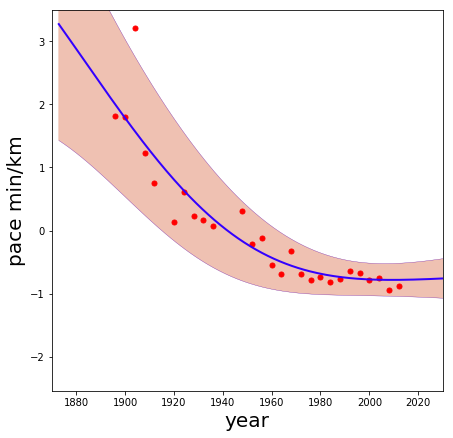

In [10]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
plot_model_output(m, ax=ax, xlabel='year', ylabel='pace min/km', 
          fontsize=20, portion=0.2)
ax.set_xlim((1870,2030))

ax.set_ylim(ylim)
plt.savefig('../../slides/diagrams/deepgp/olympic-marathon-deep-gp.svg', 
            transparent=True, frameon=True)

### Fitted GP for each layer

Now we explore the GPs the model has used to fit each layer. First of all, we look at the hidden layer.

In [11]:
def visualize(self, xlabel='input', ylabel='output', 
              xlim=None, ylim=None, fontsize=20):
    """Visualize the layers in a deep GP with one-d input and output."""
    last_name = xlabel
    last_x = self.X
    for i, layer in enumerate(reversed(self.layers)):
        if i>0:
            plt.plot(last_x, layer.X.mean, 'r.',markersize=10)
            last_x=layer.X.mean

            name = 'layer ' + str(i)
            plt.xlabel(last_name, fontsize=fontsize)
            plt.ylabel(name, fontsize=fontsize)
            last_name=name

        xt = plot.pred_range(last_x)
        yt_mean, yt_var = layer.predict(xt)
        yt_sd = np.sqrt(yt_var)
        gpplot(xt,yt_mean,yt_mean-2*yt_sd,yt_mean+2*yt_sd)
        if i==0 and xlim is not None:
            pass
        
    plt.plot(last_x, self.Y, 'r.',markersize=10)
    plt.xlabel(last_name, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    if ylim is not None:
        pass

# Bind the new method to the Deep GP object.
deepgp.DeepGP.visualize=visualize


In [12]:
def posterior_sample(self, X, **kwargs):
    """Give a sample from the posterior of the deep GP."""
    Z = X
    for i, layer in enumerate(reversed(self.layers)):
        Z = layer.posterior_samples(Z, size=1, **kwargs)       
    return Z
deepgp.DeepGP.posterior_sample = posterior_sample


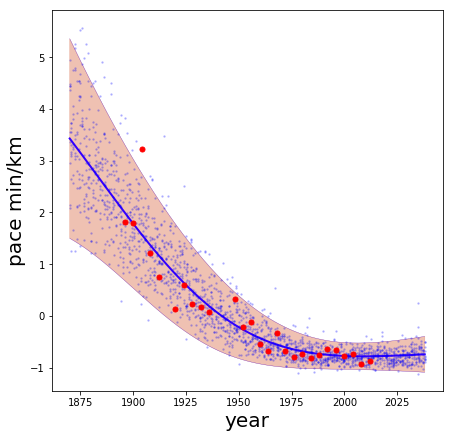

In [13]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
def plot_model_sample(model, samps=10, ax=None, xlabel='$x$', ylabel='$y$', 
                      fontsize=20, portion=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=plot.big_figsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    xt = plot.pred_range(model.X, portion=portion)
    yt_mean, yt_var = model.predict(xt)
    yt_sd=np.sqrt(yt_var)
    _ = gpplot(xt,
               yt_mean,
               yt_mean-2*yt_sd,
               yt_mean+2*yt_sd, 
               ax=ax)
    for i in range(samps):
        a = model.posterior_sample(xt)
        ax.plot(xt, a, 'b.',markersize=3, alpha=0.2)
    ax.plot(model.X, model.Y, 'r.',markersize=10)

plot_model_sample(m, samps=10, ax=ax, xlabel='year', ylabel='pace min/km', portion = 0.225)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp-samples.svg', 
                  transparent=True, frameon=True)


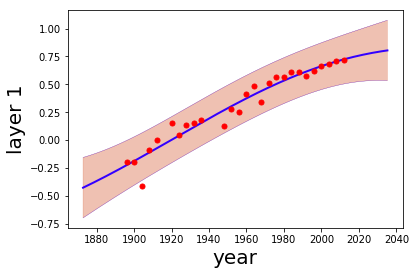

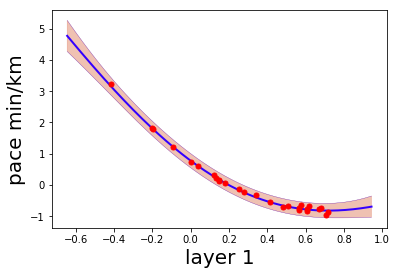

In [14]:
m.visualize(xlabel='year',ylabel='pace min/km',xlim=(1870,2030), ylim=(2.5,6.5))

In [15]:
zt_mean, zt_var = m.layer_1.predict(xt)
zt_sd = np.sqrt(zt_var)


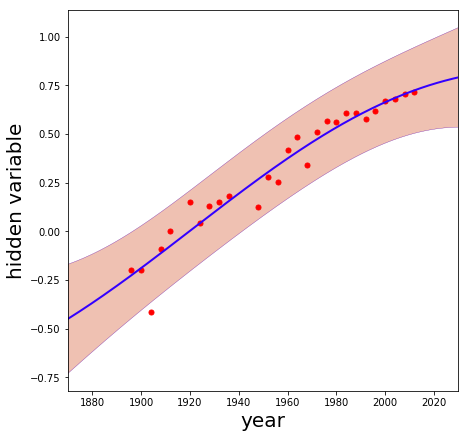

In [17]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, m.obslayer.X.mean, 'r.',markersize=10)
xt = np.linspace(1870,2030,200)[:,np.newaxis]

_ = gpplot(xt,
           zt_mean,
           zt_mean-2*zt_sd,
           zt_mean+2*zt_sd,
           ax=ax)


ax.set_ylabel('hidden variable', fontsize=20)
ax.set_xlabel('year', fontsize=20)
ax.set_xlim((1870,2030))
limz = ax.get_ylim()
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp-layer-1.svg', 
                  transparent=True, frameon=True)


In [18]:
zt = np.linspace(limz[0]-0.1,limz[1]+0.1,200)[:,np.newaxis]
yt_mean, yt_var = m.obslayer.predict(zt)
yt_sd=np.sqrt(yt_var)

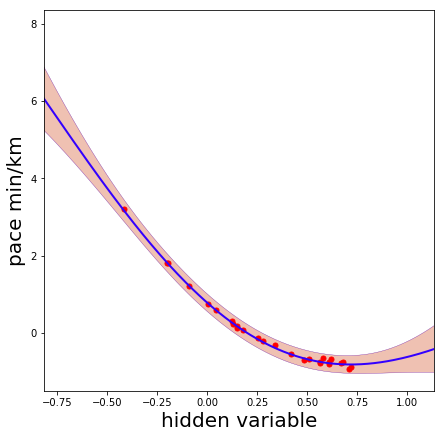

In [19]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.obslayer.X.mean, y, 'r.',markersize=10)

_ = gpplot(zt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd, 
           ax=ax)

ax.set_xlabel('hidden variable', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
#ax.set_ylim((2.5,6.5))
ax.set_xlim(limz)

mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/olympic-marathon-deep-gp-layer-2.svg',
                  transparent=True, frameon=True)

### Motorcycle Crash Data

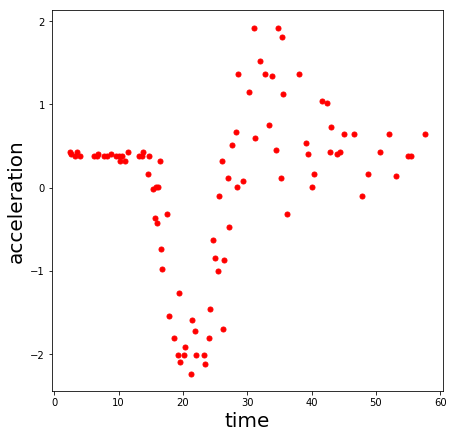

In [20]:
import pods
data = pods.datasets.mcycle()
x = data['X']
y = data['Y']
y = y - y.mean()
y = y/np.sqrt(y.var())
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
_ = ax.set_xlabel('time', fontsize=20)
_ = ax.set_ylabel('acceleration', fontsize=20)

mlai.write_figure(filename='../../slides/diagrams/datasets/motorcycle-helmet.svg', 
            transparent=True, frameon=True)

### Fit a GP Model

In [21]:
m_full = GPy.models.GPRegression(x,y)
_ = m_full.optimize() # Optimize parameters of covariance function


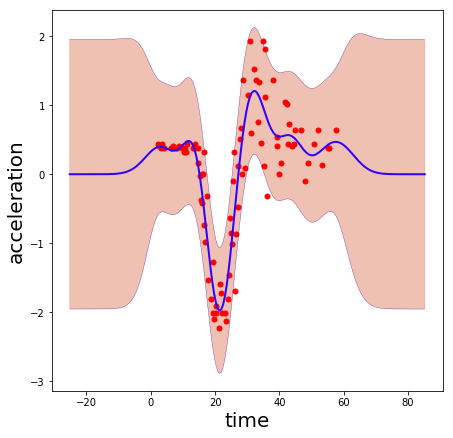

In [22]:
fig, ax=plt.subplots(figsize=plot.big_figsize)
plot_model_output(m_full, ax=ax, xlabel='time', ylabel='acceleration', fontsize=20, portion=0.5)
ylim=ax.get_ylim()
mlai.write_figure(fig=fig,filename='../../slides/diagrams/gp/motorcycle-helmet-gp.svg', 
            transparent=True, frameon=True)

In [23]:
layers = [y.shape[1], 1, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=y, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)



m.initialize()

In [24]:
#for layer in m.layers:
#    layer.likelihood.variance=0.001
#    layer.kern.lengthscale = layer.kern.lengthscale/3
#m.layers[-1].lengthscale = 5
    

In [25]:
m.staged_optimize(iters=(1000,1000,10000), messages=(True, True, True))

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0000   2.301104e+03           nan 
    00s16  0004   7.553973e+02   5.827422e+04 
    00s18  0005   6.362668e+02   6.503099e+04 
    02s19  0196   2.464689e+02   1.573889e+01 
    06s20  0664   2.450195e+02   1.544984e-01 
    08s21  0918   2.449882e+02   1.481995e-02 
    08s87  1002   2.449827e+02   3.125771e-03 
Runtime:     08s87
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   2.449827e+02   3.133991e+04 
    00s13  0007   1.856123e+02   5.410989e+03 
    00s19  0010   1.746876e+02   1.155161e+03 
    01s20  0130   9.563654e+01   1.853562e+02 
    03s21  0376   8.583216e+01   1.449147e+01 
    08s38  1002   8.563504e+01   3.082776e-01 
Runtime:     08s38
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code

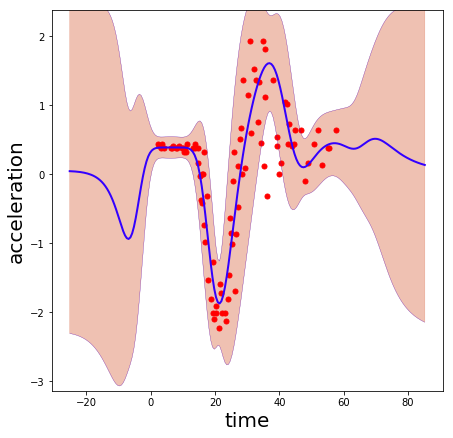

In [26]:
fig, ax=plt.subplots(figsize=plot.big_figsize)
plot_model_output(m, ax=ax, xlabel='time', ylabel='acceleration', fontsize=20, portion=0.5)
ax.set_ylim(ylim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/motorcycle-helmet-deep-gp.svg', 
            transparent=True, frameon=True)

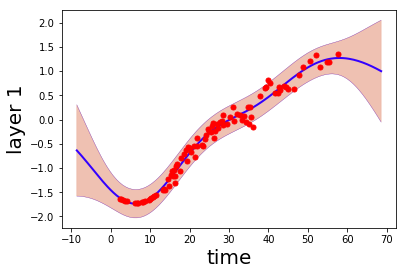

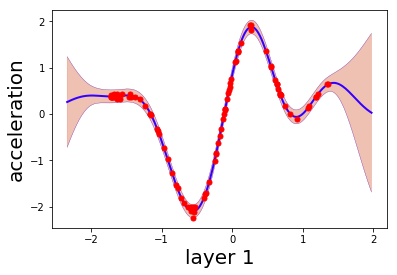

In [27]:
m.visualize(xlabel="time", ylabel="acceleration")

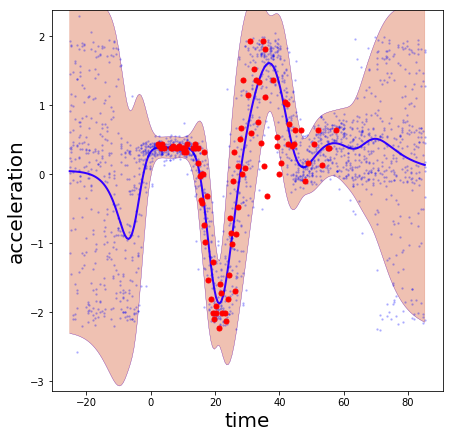

In [29]:
fig, ax=plt.subplots(figsize=plot.big_figsize)
plot_model_sample(m, samps=10, ax=ax, xlabel='time', ylabel='acceleration', portion = 0.5)
ax.set_ylim(ylim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/motorcycle-helmet-gp-samples.svg', 
                  transparent=True, frameon=True)

### Robot Wireless Data

The robot wireless data is taken from an experiment run by Brian Ferris at University of Washington. It consists of the measurements of WiFi access point signal strengths as Brian walked in a loop.

In [ ]:
data=pods.datasets.robot_wireless()

x = np.linspace(0,1,215)[:, np.newaxis]
y = data['Y']

The ground truth is recorded in the data, the actual loop is given in the plot below.

In [ ]:
f, ax = plt.subplots(figsize=plot.big_figsize)
plt.plot(data['X'][:, 1], data['X'][:, 2], 'r.', markersize=5)
ax.set_xlabel('x position', fontsize=20)
ax.set_ylabel('y position', fontsize=20)
plt.savefig('../../slides/diagrams/datasets/robot-wireless-ground-truth.svg', transparent=True, frameon=True)

We will ignore this ground truth in making our predictions, but see if the model can recover something similar in one of the latent layers.

In [ ]:
output_dim=1
xlim = (-0.3, 1.3)
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y[:, output_dim:output_dim+1], 
            'r.', markersize=5)

ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)

ax.set_xlim(xlim)
ylim = ax.get_ylim()
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/datasets/robot-wireless-dim-' + str(output_dim) + '.svg', 
            transparent=True, frameon=True)

Perform a Gaussian process fit on the data using GPy.

In [ ]:
m_full = GPy.models.GPRegression(x,y[:, output_dim:output_dim+1])
_ = m_full.optimize() # Optimize parameters of covariance function


In [ ]:
xt = np.linspace(xlim[0], xlim[1],200)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

In [ ]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y[:, output_dim:output_dim+1], 'r.',markersize=5)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)

_ = gpplot(xt,
           yt_mean,
           yt_mean-2*yt_sd,
           yt_mean+2*yt_sd, 
           ax=ax)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/gp/robot-wireless-gp-dim-' + str(output_dim) + '.svg', transparent=True, frameon=True)

In [ ]:
layers = [y.shape[1], 10, 5, 2, 2, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]

In [ ]:
m = deepgp.DeepGP(layers,Y=y, X=x, inits=inits, 
                  kernels=kernels,
                  num_inducing=50, back_constraint=False)
m.initialize()
m.staged_optimize(messages=(True,True,True))

In [ ]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.layers[-1].latent_space.mean[:, 0], 
        m.layers[-1].latent_space.mean[:, 1], 
        'r.-', markersize=5)

ax.set_xlabel('latent dimension 1', fontsize=20)
ax.set_ylabel('latent dimension 2', fontsize=20)

plt.savefig('../../slides/diagrams/deepgp/robot-wireless-latent-space.svg', 
            transparent=True, frameon=True)

In [ ]:
for layer in m.layers:
    print(layer.kern.lengthscale)

In [ ]:
x

In [ ]:
xt = np.linspace(xlim[0],xlim[1],200)[:,np.newaxis]
yt_mean, yt_var = m.predict(xt)
yt_sd=np.sqrt(yt_var)


In [ ]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y[:, output_dim:output_dim+1], 'r.',markersize=5)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)

_ = gpplot(xt,yt_mean[:, output_dim:output_dim+1],
           yt_mean[:, output_dim:output_dim+1]-2*yt_sd[:, output_dim:output_dim+1],
           yt_mean[:, output_dim:output_dim+1]+2*yt_sd[:, output_dim:output_dim+1], ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/deepgp/robot-wireless-deep-gp-dim-' + str(output_dim) + '.svg', 
            transparent=True, frameon=True)

# Step Function

Finally, we consider a simple step function data set. 

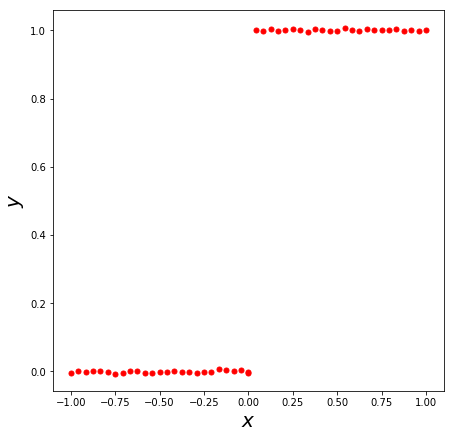

In [47]:
num_data=50
gap = 0.0
noise=0.00001
x = np.vstack((np.linspace(-1, -gap/2.0, num_data/2)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_data/2)[:, np.newaxis]))
y = (x>0) + np.random.randn(num_data, 1)*np.sqrt(noise)
fig, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
_ = ax.set_xlabel('$x$', fontsize=20)
_ = ax.set_ylabel('$y$', fontsize=20)

mlai.write_figure(fig=fig, filename='../../slides/diagrams/datasets/step-function.svg', 
            transparent=True, frameon=True)

In [48]:
m_full = GPy.models.GPRegression(x,y)
_ = m_full.optimize() # Optimize parameters of covariance function


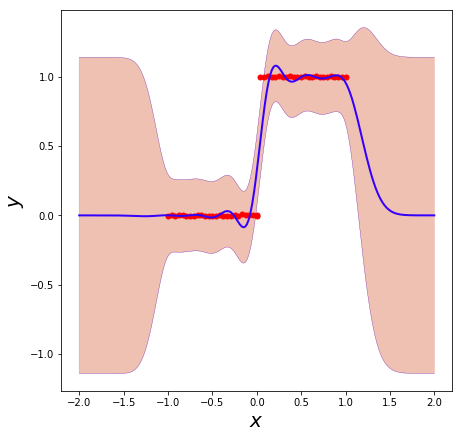

In [49]:
fig, ax=plt.subplots(figsize=plot.big_figsize)
plot_model_output(m_full, ax=ax, fontsize=20, portion=0.5)
ylim=ax.get_ylim()
mlai.write_figure(fig=fig,filename='../../slides/diagrams/gp/step-function-gp.svg', 
            transparent=True, frameon=True)

In [50]:
layers = [y.shape[1], 1,x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i)]
m = deepgp.DeepGP(layers,Y=y, X=x, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=20, back_constraint=False)

In [51]:
m.initialize()


In [52]:
m.staged_optimize()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s08  00006  -9.785343e+01   6.766128e+03 
    00s18  00012  -1.219890e+02   2.253369e+03 
    03s19  00243  -1.363302e+02   8.438839e-02 
    07s63  00635  -1.363889e+02   3.243636e-03 
Runtime:     07s63
Optimization status: Errorb'ABNORMAL_TERMINATION_IN_LNSRCH'



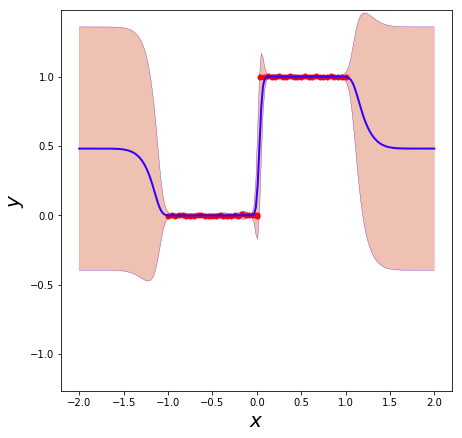

In [57]:
fig, ax=plt.subplots(figsize=plot.big_figsize)
plot_model_output(m, ax=ax, fontsize=20, portion=0.5)
ax.set_ylim(ylim)
mlai.write_figure(filename='../../slides/diagrams/deepgp/step-function-deep-gp.svg', 
            transparent=True, frameon=True)

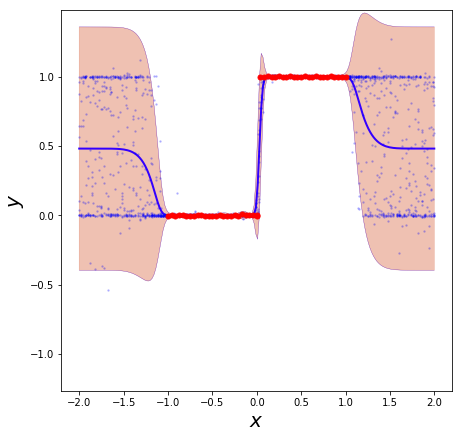

In [59]:
fig, ax=plt.subplots(figsize=plot.big_figsize)
plot_model_sample(m, samps=10, ax=ax, portion = 0.5)
ax.set_ylim(ylim)
mlai.write_figure(figure=fig, filename='../../slides/diagrams/deepgp/step-function-deep-gp-sample.svg', 
                  transparent=True, frameon=True)

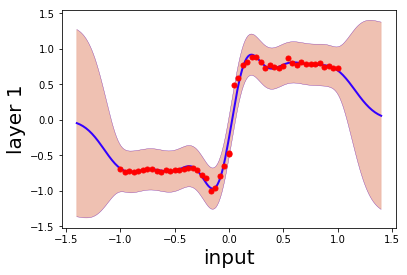

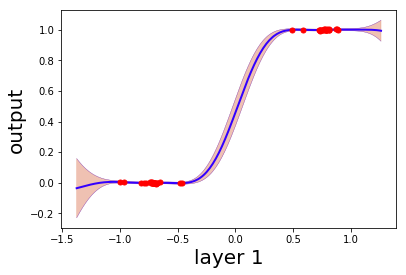

In [56]:
m.visualize()

In [ ]:
m.obslayer.likelihood.variance

In [ ]:
f, ax = plt.subplots(figsize=plot.wide_figsize)
xt = plot.pred_range(m.X, portion=0.5)
samps=1
a=m.posterior_samples(xt, size=samps)
for i in range(samps):
    ax.plot(xt, a[:, i:i+1], '.-', markersize=5)
ax.plot(x,y, 'r.',markersize=10)

In [ ]:
m